#Importation du DATA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv('/content/drive/MyDrive/ObesityDataSet_raw_and_data_sinthetic.csv')

In [9]:
data.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Prétraitement des données

##Nettoyage des données


**Vérifier le nombre de valeurs manquantes pour chaque colonne.**

In [10]:
data.isna().sum()

,0
Age,0
Gender,0
Height,0
Weight,0
CALC,0
FAVC,0
FCVC,0
NCP,0
SCC,0
SMOKE,0


* **Vérifier les duplicates**

In [11]:
duplicates = data.drop_duplicates(inplace=True)
print(duplicates)

None


* la base est completement nettoyée.

#Préparation des données

* **Sélection des Features [Age, Gender, Height, Weight, NObeyesdad]**

In [12]:
# Liste des colonnes à conserver
colonnes_utilisees = ['Age','Gender','Height', 'Weight', 'NObeyesdad']
# Supprimer les colonnes qui ne sont pas utilisées
data= data[colonnes_utilisees].copy()
# Afficher les premières lignes du dataframe après la suppression des colonnes
print(data.head())

    Age  Gender  Height  Weight           NObeyesdad
0  21.0  Female    1.62    64.0        Normal_Weight
1  21.0  Female    1.52    56.0        Normal_Weight
2  23.0    Male    1.80    77.0        Normal_Weight
3  27.0    Male    1.80    87.0   Overweight_Level_I
4  22.0    Male    1.78    89.8  Overweight_Level_II


* **Exploration des données**

* **Analyse de la Taille et du Poids**

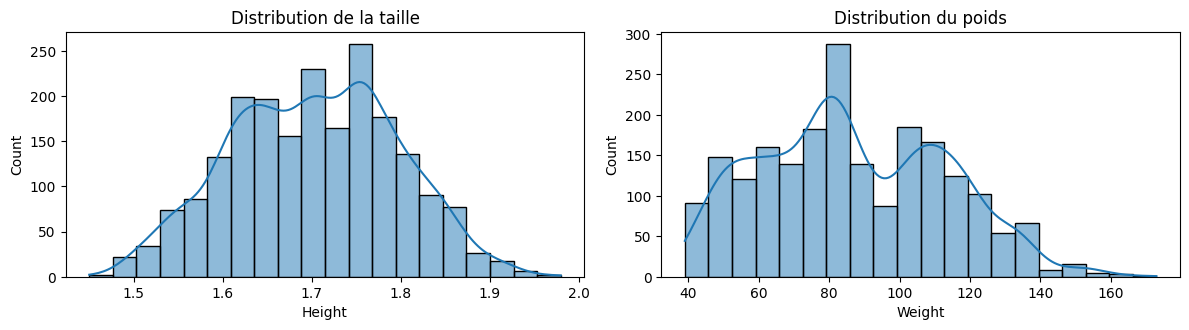

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 3)
sns.histplot(data['Height'], bins=20, kde=True)
plt.title('Distribution de la taille')

plt.subplot(2, 2, 4)
sns.histplot(data['Weight'], bins=20, kde=True)
plt.title('Distribution du poids')

plt.tight_layout()
plt.show()

* **Répartition des catégories de poids après nettoyage des données**

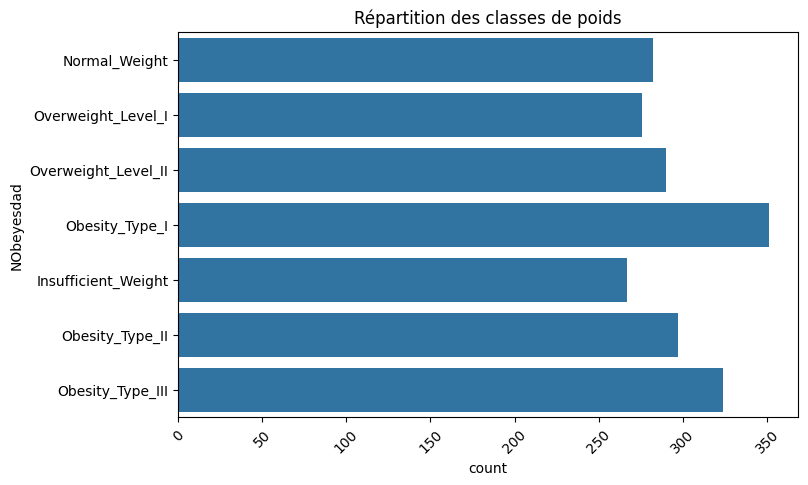

In [14]:
# Analyse des variables cibles
plt.figure(figsize=(8, 5))
sns.countplot(data['NObeyesdad'])
plt.title('Répartition des classes de poids')
plt.xticks(rotation=45)
plt.show()


la BD est bien équilibré en termes de représentation des différentes classes de poids.

* **Analyse de l'âge par sexe**

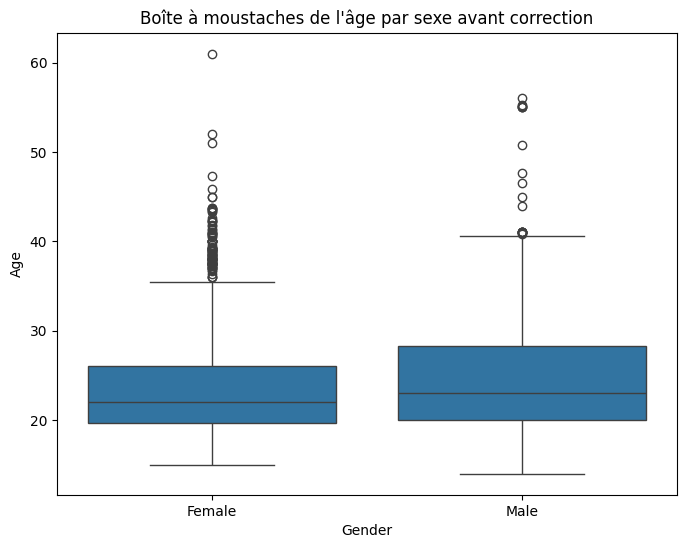

In [15]:
# Affichage de la boîte à moustaches de l'âge par sexe
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Age', data=data)
plt.title('Boîte à moustaches de l\'âge par sexe avant correction')
plt.show()


* **Identification et correction des outliers pour chaque groupe de sexe avec la méthode des IQR**

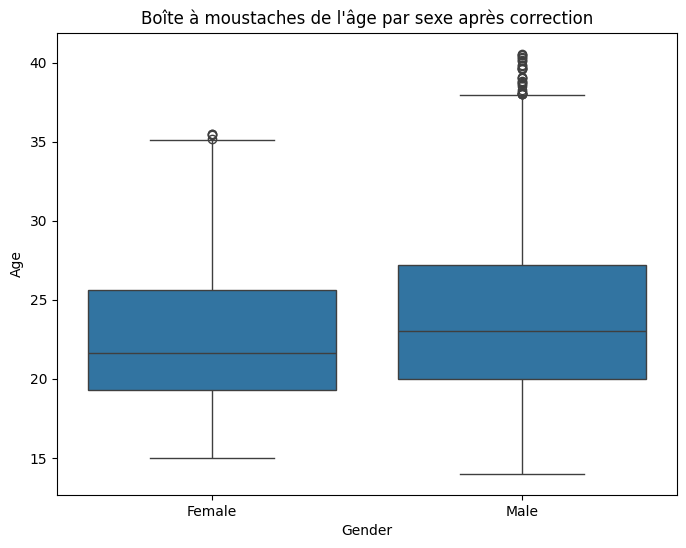

In [16]:
data_cleaned = pd.DataFrame()
for gender, group_data in data.groupby('Gender'):
    Q1 = group_data['Age'].quantile(0.25)
    Q3 = group_data['Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrage des données pour exclure les outliers pour chaque groupe de sexe
    group_data_cleaned = group_data[(group_data['Age'] >= lower_bound) & (group_data['Age'] <= upper_bound)]

    # Concaténer les données nettoyées de chaque groupe de sexe
    data_cleaned = pd.concat([data_cleaned, group_data_cleaned])

# Affichage de la boîte à moustaches de l'âge par sexe après correction
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Age', data=data_cleaned)
plt.title('Boîte à moustaches de l\'âge par sexe après correction')
plt.show()

* **Calcul de la corrélation entre l'âge et d'autres variables après correction des outliers**

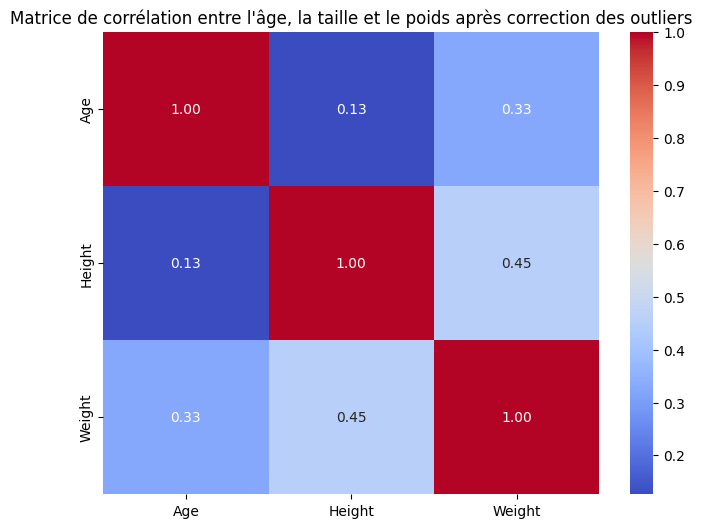

In [17]:
correlation_age = data_cleaned[['Age', 'Height', 'Weight']].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_age, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation entre l\'âge, la taille et le poids après correction des outliers')
plt.show()

 la corrélation ne signifie pas causalité - d'autres facteurs peuvent influencer ces variables.

* **Sélectionner les colonnes aprés corrections**



In [18]:
# Liste des colonnes à conserver
colonnes_utilisees = ['Age','Gender','Height', 'Weight', 'NObeyesdad']
# Supprimer les colonnes qui ne sont pas utilisées
data= data_cleaned[colonnes_utilisees].copy()
# Afficher les premières lignes du dataframe après la suppression des colonnes
print(data.head())

     Age  Gender  Height  Weight           NObeyesdad
0   21.0  Female    1.62    64.0        Normal_Weight
1   21.0  Female    1.52    56.0        Normal_Weight
6   23.0  Female    1.50    55.0        Normal_Weight
11  21.0  Female    1.72    80.0  Overweight_Level_II
15  22.0  Female    1.70    66.0        Normal_Weight


* **Codage des variables catégorielles**



In [19]:
# Ajouter la colonne "Gender_Male" avec des indicateurs binaires pour les valeurs "Male"
data['Gender_Male'] = (data['Gender'] == 'Male').astype(int)
# Ajouter la colonne "Gender_Male" avec des indicateurs binaires pour les valeurs "Male"
data['Gender_Female'] = (data['Gender'] == 'Female').astype(int)
# Supprimer la colonne "Gender" d'origine si nécessaire
data.drop(columns=['Gender'], inplace=True)
# Afficher le DataFrame mis à jour
print(data)# Ajouter la colonne "Gender_Male" avec des indicateurs binaires pour les valeurs "Male"


            Age    Height      Weight           NObeyesdad  Gender_Male  \
0     21.000000  1.620000   64.000000        Normal_Weight            0   
1     21.000000  1.520000   56.000000        Normal_Weight            0   
6     23.000000  1.500000   55.000000        Normal_Weight            0   
11    21.000000  1.720000   80.000000  Overweight_Level_II            0   
15    22.000000  1.700000   66.000000        Normal_Weight            0   
...         ...       ...         ...                  ...          ...   
1794  30.642430  1.653876  102.583895      Obesity_Type_II            1   
1795  20.068432  1.657132  105.580491      Obesity_Type_II            1   
1796  20.914366  1.644751  101.067988      Obesity_Type_II            1   
1797  25.512048  1.660761  104.321463      Obesity_Type_II            1   
1798  26.844812  1.691510  102.595180      Obesity_Type_II            1   

      Gender_Female  
0                 1  
1                 1  
6                 1  
11         

* **Séparation des fonctionnalités et de la variable cible**

In [20]:
# Séparation des fonctionnalités et de la variable cible
X = data.drop(columns=["NObeyesdad"])  # Fonctionnalités
y = data["NObeyesdad"]  # Variable cible

In [21]:
# Affichage des fonctionnalités et de la variable cible
print("Fonctionnalités (X):")
print(X.head())  # Affichage des premières lignes des fonctionnalités
print("\nVariable cible (y):")
print(y.head())  # Affichage des premières lignes de la variable cible

Fonctionnalités (X):
     Age  Height  Weight  Gender_Male  Gender_Female
0   21.0    1.62    64.0            0              1
1   21.0    1.52    56.0            0              1
6   23.0    1.50    55.0            0              1
11  21.0    1.72    80.0            0              1
15  22.0    1.70    66.0            0              1

Variable cible (y):
0           Normal_Weight
1           Normal_Weight
6           Normal_Weight
11    Overweight_Level_II
15          Normal_Weight
Name: NObeyesdad, dtype: object


#KNN

* **Division des données en ensembles d'entraînement et de test**

In [22]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Affichage des ensembles d'entraînement
print("Ensemble d'entraînement - Fonctionnalités (X_train) :")
print(X_train.head())
print("\nEnsemble d'entraînement - Variable cible (y_train) :")
print(y_train.head())

# Affichage des ensembles de test
print("\nEnsemble de test - Fonctionnalités (X_test) :")
print(X_test.head())
print("\nEnsemble de test - Variable cible (y_test) :")
print(y_test.head())

Ensemble d'entraînement - Fonctionnalités (X_train) :
            Age    Height      Weight  Gender_Male  Gender_Female
1324  22.480889  1.605662   82.470375            0              1
2013  18.826782  1.746416  133.747012            0              1
1492  18.000000  1.782722  108.044313            1              0
2087  26.000000  1.633442  111.821817            0              1
2036  25.992898  1.638075  105.036522            0              1

Ensemble d'entraînement - Variable cible (y_train) :
1324      Obesity_Type_I
2013    Obesity_Type_III
1492      Obesity_Type_I
2087    Obesity_Type_III
2036    Obesity_Type_III
Name: NObeyesdad, dtype: object

Ensemble de test - Fonctionnalités (X_test) :
            Age    Height      Weight  Gender_Male  Gender_Female
1924  21.704699  1.787614  137.858254            0              1
1937  21.140165  1.713133  133.735889            0              1
1461  22.088059  1.803132  106.329569            1              0
762   22.549208  1.629194   

* **Initialisation du classifieur k-NN**

On choisit aleatoirement k=5

In [24]:
knn = KNeighborsClassifier(n_neighbors=5)

* **Entraînement du modèle**

In [25]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

* **Prédictions sur l'ensemble de test**

In [26]:
y_pred = knn.predict(X_test)

* **Calcul de l'accuracy**

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8632911392405064


* **Matrice de confusion**

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[63  4  0  0  0  0  0]
 [11 31  0  0  0  8  2]
 [ 0  0 61  0  3  0  5]
 [ 0  0  3 57  0  0  0]
 [ 0  0  0  0 45  0  0]
 [ 0  6  0  0  0 39  3]
 [ 0  3  1  0  0  5 45]]


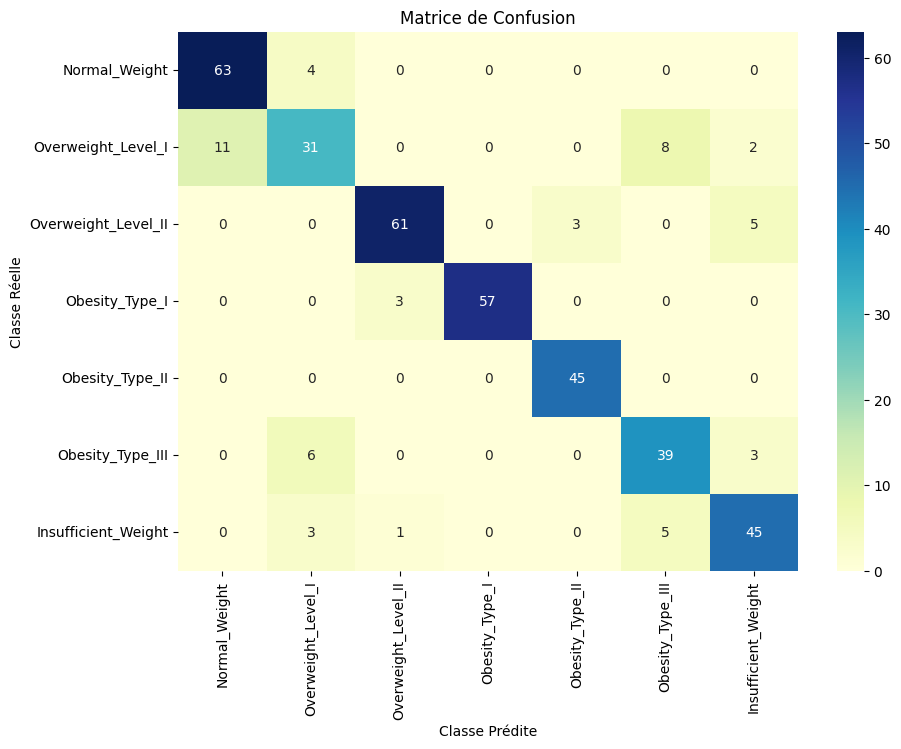

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# Étiquettes des classes
class_labels = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Insufficient_Weight']

# Création du heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

* **Rapport de Classification**

In [30]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.94      0.89        67
      Normal_Weight       0.70      0.60      0.65        52
     Obesity_Type_I       0.94      0.88      0.91        69
    Obesity_Type_II       1.00      0.95      0.97        60
   Obesity_Type_III       0.94      1.00      0.97        45
 Overweight_Level_I       0.75      0.81      0.78        48
Overweight_Level_II       0.82      0.83      0.83        54

           accuracy                           0.86       395
          macro avg       0.86      0.86      0.86       395
       weighted avg       0.86      0.86      0.86       395



*L'interprétation du rapport de classification montre que le modèle actuel présente des points faibles qu'il est possible d'améliorer*




**je vais refaire le travail mais avec des changement**


In [31]:
data = pd.read_csv('/content/drive/MyDrive/ObesityDataSet_raw_and_data_sinthetic.csv')

#Préparation des données

* **on va choisir des autres features sur lesqueles on va travailler**

In [32]:
# Liste des colonnes à conserver
colonnes_utilisees = ['Height', 'Weight','family_history_with_overweight','FAVC', 'NObeyesdad']
# Supprimer les colonnes qui ne sont pas utilisées
df = data[colonnes_utilisees].copy()
print(df.head())

   Height  Weight family_history_with_overweight FAVC           NObeyesdad
0    1.62    64.0                            yes   no        Normal_Weight
1    1.52    56.0                            yes   no        Normal_Weight
2    1.80    77.0                            yes   no        Normal_Weight
3    1.80    87.0                             no   no   Overweight_Level_I
4    1.78    89.8                             no   no  Overweight_Level_II


* **Obesity level of people that eats caloric foods**

Text(0.5, 1.0, 'Obesity Level of people that eats high caloric food')

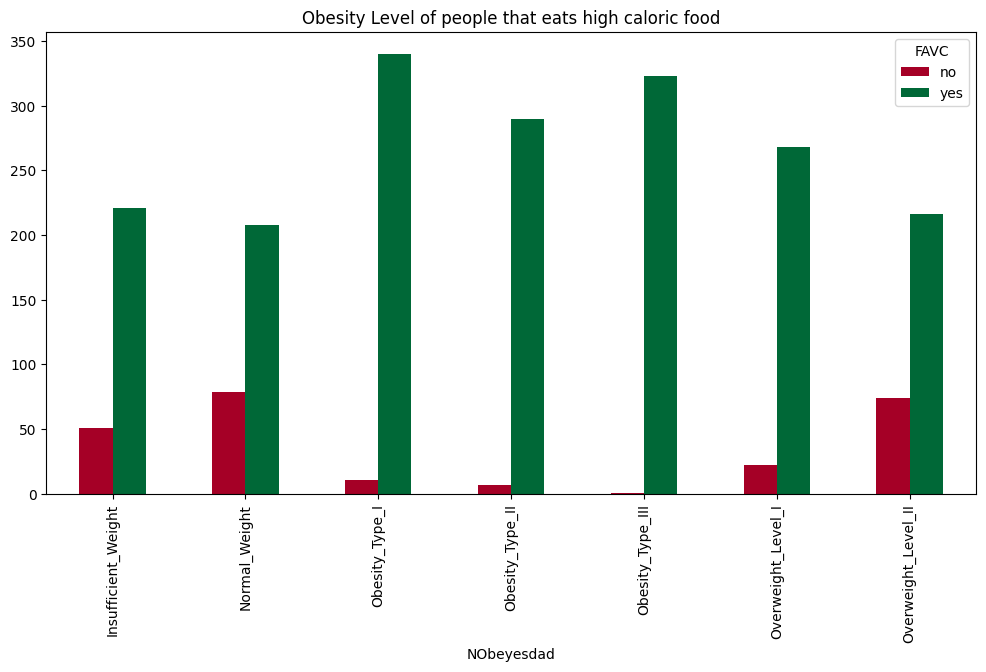

In [33]:
ob_caloric = data.groupby('NObeyesdad')['FAVC'].value_counts().unstack()

ob_caloric.plot(kind='bar', colormap='RdYlGn', figsize=(12, 6))
plt.title('Obesity Level of people that eats high caloric food')

* **Affichage de la boîte à moustaches de la taille (Height)**

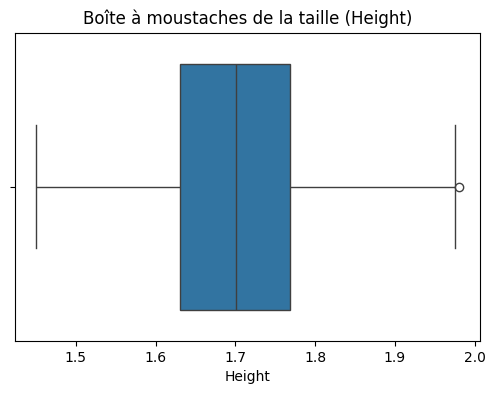

In [34]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['Height'])
plt.title('Boîte à moustaches de la taille (Height)')
plt.show()


* **Identification des outliers pour la taille (Height) avec la méthode des IQR**

In [35]:
# Identification des outliers pour la taille (Height) avec la méthode des IQR
Q1_height = data['Height'].quantile(0.25)
Q3_height = data['Height'].quantile(0.75)
IQR_height = Q3_height - Q1_height
lower_bound_height = Q1_height - 1.5 * IQR_height
upper_bound_height = Q3_height + 1.5 * IQR_height

* **Correction des outliers pour la taille (Height)**

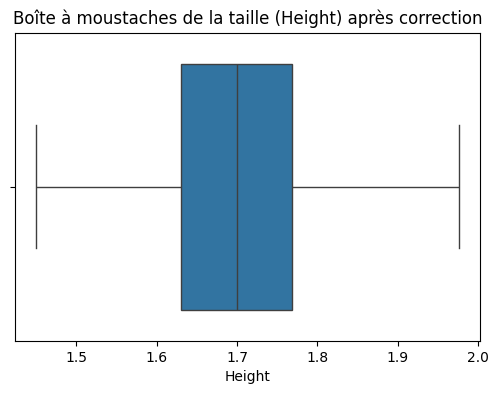

In [36]:
# Correction des outliers pour la taille (Height)
data_cleaned_height = data[(data['Height'] >= lower_bound_height) & (data['Height'] <= upper_bound_height)]

# Affichage de la boîte à moustaches de la taille (Height) après correction
plt.figure(figsize=(6, 4))
sns.boxplot(x=data_cleaned_height['Height'])
plt.title('Boîte à moustaches de la taille (Height) après correction')
plt.show()

* **Affichage de la boîte à moustaches du poids (Weight)**

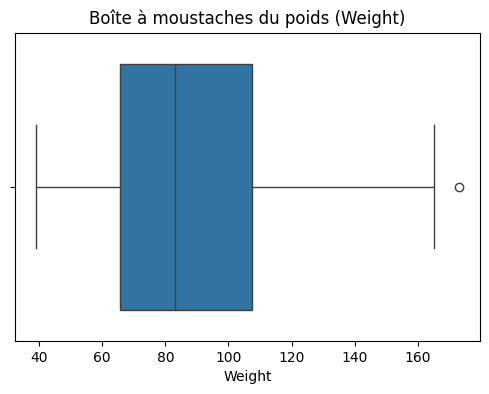

In [37]:
# Affichage de la boîte à moustaches du poids (Weight)
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['Weight'])
plt.title('Boîte à moustaches du poids (Weight)')
plt.show()


* **Identification des outliers pour le poids (Weight) avec la méthode des IQR**

In [38]:
# Identification des outliers pour le poids (Weight) avec la méthode des IQR
Q1_weight = data['Weight'].quantile(0.25)
Q3_weight = data['Weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
lower_bound_weight = Q1_weight - 1.5 * IQR_weight
upper_bound_weight = Q3_weight + 1.5 * IQR_weight

* **Correction des outliers pour le poids (Weight)**

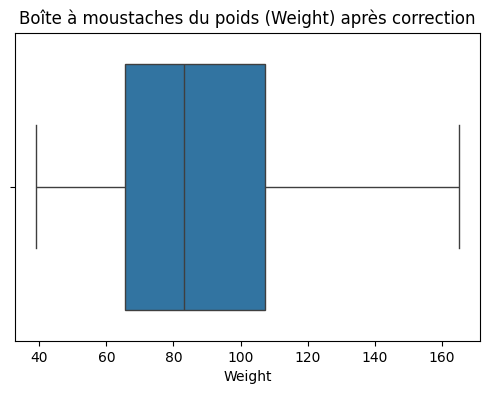

In [39]:
# Correction des outliers pour le poids (Weight)
data_cleaned_weight = data[(data['Weight'] >= lower_bound_weight) & (data['Weight'] <= upper_bound_weight)]

# Affichage de la boîte à moustaches du poids (Weight) après correction
plt.figure(figsize=(6, 4))
sns.boxplot(x=data_cleaned_weight['Weight'])
plt.title('Boîte à moustaches du poids (Weight) après correction')
plt.show()

* **Afficher la DataFrame après la correction du Wight et Height**

In [40]:
# Concaténer les DataFrames data_cleaned_height et data_cleaned_weight
data_cleaned_combined = pd.concat([data_cleaned_height, data_cleaned_weight])

# Afficher le tableau combiné
print("Data après correction des outliers pour Height et Weight :")
print(data_cleaned_combined[['Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'NObeyesdad']].head())

Data après correction des outliers pour Height et Weight :
   Height  Weight family_history_with_overweight FAVC           NObeyesdad
0    1.62    64.0                            yes   no        Normal_Weight
1    1.52    56.0                            yes   no        Normal_Weight
2    1.80    77.0                            yes   no        Normal_Weight
3    1.80    87.0                             no   no   Overweight_Level_I
4    1.78    89.8                             no   no  Overweight_Level_II


* **Normalisation des données**

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Créer une instance de MinMaxScaler
scaler = MinMaxScaler()

# Sélectionner les colonnes à normaliser
columns_to_normalize = ['Height', 'Weight']

# Normaliser les données dans les colonnes sélectionnées
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Afficher les données normalisées
print(df.head())

     Height    Weight family_history_with_overweight FAVC           NObeyesdad
0  0.320755  0.186567                            yes   no        Normal_Weight
1  0.132075  0.126866                            yes   no        Normal_Weight
2  0.660377  0.283582                            yes   no        Normal_Weight
3  0.660377  0.358209                             no   no   Overweight_Level_I
4  0.622642  0.379104                             no   no  Overweight_Level_II


 * **Codage des variables catégorielles**

In [42]:
# Supprimer les doublons dans le DataFrame data_cleaned_combined
df = df.drop_duplicates()

# Remplacer True par 1 et False par 0 dans la colonne "family_history_with_overweight" et "FAVC"
df['family_history_with_overweight'] = df['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df['FAVC'] = df['FAVC'].replace({'yes': 1, 'no': 0})

# Afficher les premières lignes du DataFrame après la suppression des doublons et la modification des valeurs
print(df.head())

     Height    Weight  family_history_with_overweight  FAVC  \
0  0.320755  0.186567                               1     0   
1  0.132075  0.126866                               1     0   
2  0.660377  0.283582                               1     0   
3  0.660377  0.358209                               0     0   
4  0.622642  0.379104                               0     0   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_Weight  
3   Overweight_Level_I  
4  Overweight_Level_II  


<ipython-input-42-82d9971776ad>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['family_history_with_overweight'] = df['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
<ipython-input-42-82d9971776ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family_history_with_overweight'] = df['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
<ipython-input-42-82d9971776ad>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the

In [43]:
# Supprimer les doublons dans le DataFrame data_cleaned_combined
data_cleaned_combined = data_cleaned_combined.drop_duplicates()

# Remplacer True par 1 et False par 0 dans la colonne "family_history_with_overweight" et "FAVC"
df['family_history_with_overweight'] = data_cleaned_combined['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df['FAVC'] = data_cleaned_combined['FAVC'].replace({'yes': 1, 'no': 0})

# Afficher les premières lignes du DataFrame après la suppression des doublons et la modification des valeurs
print(df.head())

     Height    Weight  family_history_with_overweight  FAVC  \
0  0.320755  0.186567                               1     0   
1  0.132075  0.126866                               1     0   
2  0.660377  0.283582                               1     0   
3  0.660377  0.358209                               0     0   
4  0.622642  0.379104                               0     0   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_Weight  
3   Overweight_Level_I  
4  Overweight_Level_II  


<ipython-input-43-3933236e86dd>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['family_history_with_overweight'] = data_cleaned_combined['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
<ipython-input-43-3933236e86dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family_history_with_overweight'] = data_cleaned_combined['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
<ipython-input-43-3933236e86dd>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be remo

* **Filtrer Data**

In [44]:
# Filtrer les lignes avec des valeurs différentes de 1 ou 0 dans les colonnes spécifiées
indices_to_drop = df[(df['family_history_with_overweight'] != 0) & (df['family_history_with_overweight'] != 1) |
                      (df['FAVC'] != 0) & (df['FAVC'] != 1)].index

# Supprimer les lignes correspondantes du DataFrame
df = df.drop(indices_to_drop)
df.head()

,Height,Weight,family_history_with_overweight,FAVC,NObeyesdad
0,0.320755,0.186567,1,0,Normal_Weight
1,0.132075,0.126866,1,0,Normal_Weight
2,0.660377,0.283582,1,0,Normal_Weight
3,0.660377,0.358209,0,0,Overweight_Level_I
4,0.622642,0.379104,0,0,Overweight_Level_II


* **la matrice de corrélation**

Text(0.5, 1.0, 'Matrice de corrélation entre family_history_with_overweigh,FAVC, la taille et le poids après correction des outliers')

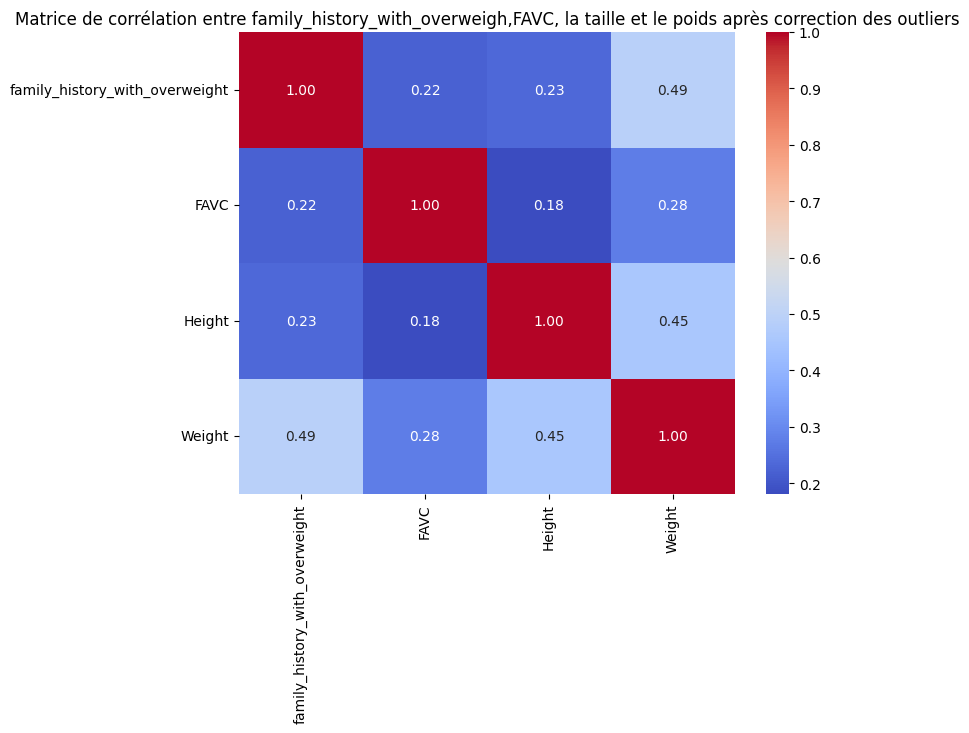

In [45]:
correlation = df[['family_history_with_overweight','FAVC','Height', 'Weight']].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation entre family_history_with_overweigh,FAVC, la taille et le poids après correction des outliers')

* **Séparation des fonctionnalités et de la variable cible**

In [46]:
X = df.drop(columns=["NObeyesdad"])  # Fonctionnalités
y = df["NObeyesdad"]  # Variable cible

In [47]:
# Affichage des fonctionnalités et de la variable cible
print("Fonctionnalités (X):")
print(X.head())  # Affichage des premières lignes des fonctionnalités
print("\nVariable cible (y):")
print(y.head())  # Affichage des premières lignes de la variable cible


Fonctionnalités (X):
     Height    Weight  family_history_with_overweight  FAVC
0  0.320755  0.186567                               1     0
1  0.132075  0.126866                               1     0
2  0.660377  0.283582                               1     0
3  0.660377  0.358209                               0     0
4  0.622642  0.379104                               0     0

Variable cible (y):
0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: NObeyesdad, dtype: object


#kNN

* **Division des données en ensembles d'entraînement et de tests**

In [48]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Affichage des ensembles d'entraînement
print("Ensemble d'entraînement - Fonctionnalités (X_train) :")
print(X_train.head())
print("\nEnsemble d'entraînement - Variable cible (y_train) :")
print(y_train.head())

# Affichage des ensembles de test
print("\nEnsemble de test - Fonctionnalités (X_test) :")
print(X_test.head())
print("\nEnsemble de test - Variable cible (y_test) :")
print(y_test.head())


Ensemble d'entraînement - Fonctionnalités (X_train) :
        Height    Weight  family_history_with_overweight  FAVC
1372  0.657272  0.482876                               1     1
1919  0.299638  0.470776                               1     1
1773  0.666428  0.592037                               1     1
1632  0.866236  0.678171                               1     1
1681  0.573994  0.588785                               1     1

Ensemble d'entraînement - Variable cible (y_train) :
1372      Obesity_Type_I
1919    Obesity_Type_III
1773     Obesity_Type_II
1632     Obesity_Type_II
1681     Obesity_Type_II
Name: NObeyesdad, dtype: object

Ensemble de test - Fonctionnalités (X_test) :
        Height    Weight  family_history_with_overweight  FAVC
1383  0.276577  0.311390                               1     1
1063  0.426326  0.303495                               1     1
1134  0.128298  0.191763                               1     0
2038  0.298647  0.495222                               1  

* **Etablir Cross Validation pour déterminer K optimal**

In [50]:
from sklearn.model_selection import cross_val_score
import builtins

# Perform 10-fold cross-validation
# Define a range of K values to test
k_test = builtins.list(range(1, 11))

# Initialize an empty list to store mean cross-validation scores for each K
mean_cv_scores = []

# Iterate over each K value
for k in k_test:
    # Initialize KNN classifier with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform 10-fold cross-validation and compute the mean score
    cv_scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)

    # Store the mean score for the current K value
    mean_cv_scores.append(mean_cv_score)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", mean_cv_scores)

# Find the optimal K value that maximizes the mean cross-validation score
optimal_k = k_test[np.argmax(mean_cv_scores)]
print("Optimal K value:", optimal_k)

Cross-validation scores: [0.71568627 0.79901961 0.94117647 0.95098039 0.93627451 0.92647059
 0.93627451 0.93137255 0.95588235 0.93627451]
Mean CV score: [0.928921568627451, 0.9284313725490195, 0.9269607843137253, 0.9279411764705883, 0.9225490196078431, 0.9181372549019609, 0.9176470588235294, 0.9117647058823529, 0.9068627450980392, 0.902941176470588]
Optimal K value: 1


* **Initialisation du classifieur k-NN**

In [51]:
knn= KNeighborsClassifier(n_neighbors=1)

* **Entraînement du modèle**

In [52]:
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

* **Prédictions sur l'ensemble de test**

In [53]:
y_pred = knn.predict(X_test)



* **Calcul de l'accuracy**

In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


* **Matrice de confusion**

In [55]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[49  3  0  0  0  0  0]
 [ 5 42  0  0  0  7  1]
 [ 0  0 66  1  0  0  1]
 [ 0  0  1 57  0  0  0]
 [ 0  0  1  2 64  0  0]
 [ 0  6  0  0  0 39  2]
 [ 0  0  1  0  0  3 57]]


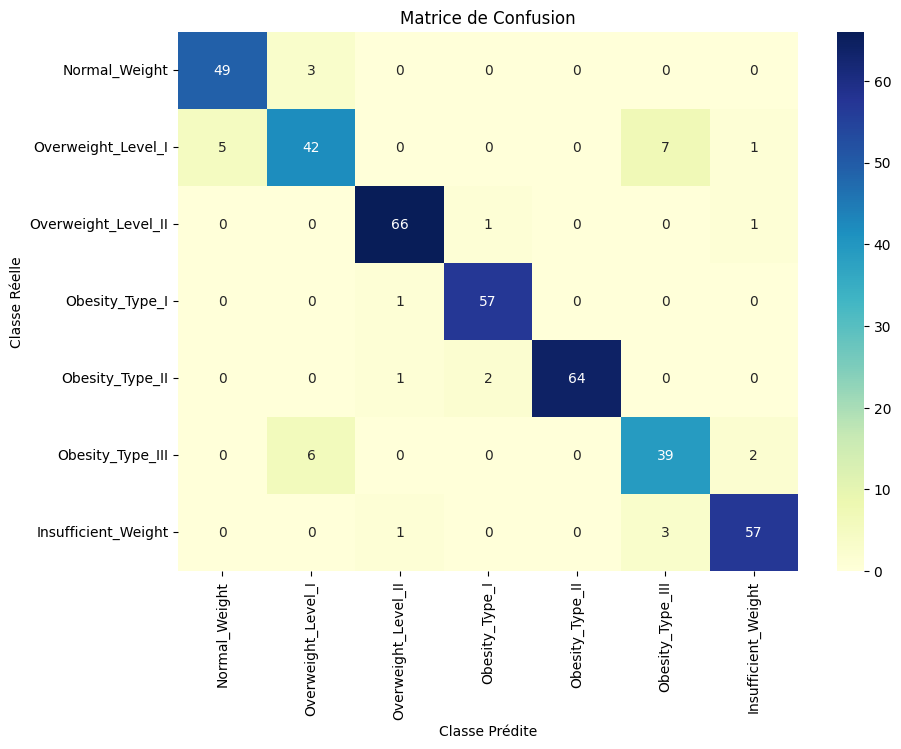

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


# Étiquettes des classes
class_labels = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Insufficient_Weight']

# Création du heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()


* **Rapport de classification**

In [57]:
# Rapport de classification
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.94      0.92        52
      Normal_Weight       0.82      0.76      0.79        55
     Obesity_Type_I       0.96      0.97      0.96        68
    Obesity_Type_II       0.95      0.98      0.97        58
   Obesity_Type_III       1.00      0.96      0.98        67
 Overweight_Level_I       0.80      0.83      0.81        47
Overweight_Level_II       0.93      0.93      0.93        61

           accuracy                           0.92       408
          macro avg       0.91      0.91      0.91       408
       weighted avg       0.92      0.92      0.92       408



Ces Résultats indique que le modèle est efficace


 **Visualisation**

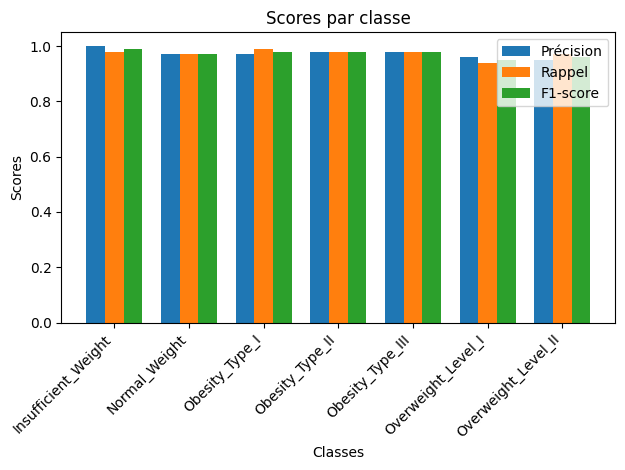

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Données du rapport de classification
classes = ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']
precision = [1.00, 0.97, 0.97, 0.98, 0.98, 0.96, 0.95]
recall = [0.98, 0.97, 0.99, 0.98, 0.98, 0.94, 0.97]
f1_score = [0.99, 0.97, 0.98, 0.98, 0.98, 0.95, 0.96]

# Création du graphique en barres
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Précision')
rects2 = ax.bar(x, recall, width, label='Rappel')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Ajout de détails au graphique
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Scores par classe')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

# Affichage du graphique
plt.tight_layout()
plt.show()



 **Test**

In [59]:
# Demander à l'utilisateur de saisir les valeurs des features
height = float(input("Entrez la taille en mètres : "))
weight = float(input("Entrez le poids en kilogrammes : "))
family_history = input("Est-ce qu'il y a des antécédents familiaux de surpoids  (yes/no) : ")
calory_food = input("Consommez-vous des calories régulièrement ? (yes/no) : ")

# Convertir la réponse de l'utilisateur en format numérique
family_history = 1 if family_history.lower() == 'yes' else 0
calory_food = 1 if calory_food.lower() == 'yes' else 0

# Créer un DataFrame avec les valeurs saisies
X_test = pd.DataFrame([[height, weight, family_history, calory_food]],
                          columns=['Height', 'Weight', 'family_history_with_overweight', 'FAVC'])



# Prédictions sur l'ensemble de test
y_pred_test = knn.predict(X_test)

# Affichage des prédictions
print("Prédictions sur l'ensemble de test :")
for prediction in y_pred_test:
    print(prediction)

Entrez la taille en mètres : 168
Entrez le poids en kilogrammes : 60
Est-ce qu'il y a des antécédents familiaux de surpoids  (yes/no) : yes
Consommez-vous des calories régulièrement ? (yes/no) : no
Prédictions sur l'ensemble de test :
Obesity_Type_I
